In [1]:
import afqinsight as afq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPool1D, MaxPooling1D, Dropout
from keras.regularizers import l1_l2, l2
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer
import kerastuner as kt

In [2]:
X, y, groups, feature_names, group_names, subjects, classes = afq.datasets.load_afq_data(
    workdir="../data/raw/cam-can",
    dwi_metrics=["dki_md", "dki_fa"],
    target_cols=["age"],
    index_col="Observations",
    fn_nodes="combined_tract_profiles.csv",
    fn_subjects="participant_data.tsv",
)

In [3]:
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
imp = SimpleImputer(strategy='median')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

In [6]:
X_train_reshaped = np.swapaxes(X_train.reshape((480, 36, 100)), 1, 2)
X_test_reshaped = np.swapaxes(X_test.reshape((160, 36, 100)), 1, 2)

In [11]:
model = Sequential()

# input: 3+D tensor with shape: batch_shape + (steps, input_dim)
# output: 3+D tensor with shape: batch_shape + (new_steps, filters) steps value might have changed due to padding or strides.
model = Sequential()
model.add(Dense(128, activation='relu', 
                input_shape=X_train_reshaped.shape[1:]))
model.add(Conv1D(24, kernel_size=2, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(32, kernel_size=2, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(128, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Conv1D(256, kernel_size=4, activation='relu'))
model.add(MaxPool1D(pool_size=2,padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_squared_error'])

In [12]:
callback = EarlyStopping(monitor='loss', patience=10)
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=100, validation_split=0.2)
loss_and_metrics = model.evaluate(X_test_reshaped, y_test, batch_size=100)
for name, metric in zip(model.metrics_names, loss_and_metrics):
    print(name, ":", metric)

Epoch 1/100
4/4 [==============================] - 1s 112ms/step - loss: 3275.1460 - mean_squared_error: 3275.1460 - val_loss: 3368.5945 - val_mean_squared_error: 3368.5945
Epoch 2/100
4/4 [==============================] - 0s 47ms/step - loss: 3029.7248 - mean_squared_error: 3029.7248 - val_loss: 2647.2463 - val_mean_squared_error: 2647.2463
Epoch 3/100
4/4 [==============================] - 0s 52ms/step - loss: 2015.9826 - mean_squared_error: 2015.9826 - val_loss: 553.3334 - val_mean_squared_error: 553.3334
Epoch 4/100
4/4 [==============================] - 0s 47ms/step - loss: 716.0751 - mean_squared_error: 716.0751 - val_loss: 573.7473 - val_mean_squared_error: 573.7473
Epoch 5/100
4/4 [==============================] - 0s 44ms/step - loss: 617.4750 - mean_squared_error: 617.4750 - val_loss: 604.1028 - val_mean_squared_error: 604.1028
Epoch 6/100
4/4 [==============================] - 0s 45ms/step - loss: 653.2988 - mean_squared_error: 653.2988 - val_loss: 698.5088 - val_mean_squar

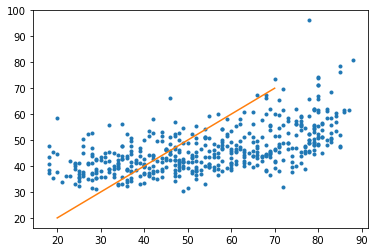

In [13]:
y_hat = model.predict(X_train_reshaped)
plt.plot(y_train, y_hat, linestyle="", marker=".")
plt.plot([20, 70], [20, 70])